In [23]:
# Блок 1: Импорт библиотек и Настройки

import os
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Flatten, Dense, Dropout, concatenate
from sklearn.model_selection import train_test_split

# --- КОНСТАНТЫ И НАСТРОЙКИ ---
DATA_ROOT = 'Dataset/'  
IMG_SIZE = (64, 64)             # Размер для ресайза картинок
SEQ_LENGTH = 20                 # Длина временного окна для сенсоров
# !!! ПРОВЕРЬТЕ И ПРИ НЕОБХОДИМОСТИ ИЗМЕНИТЕ ЭТИ ИНДЕКСЫ !!!
SENSOR_COLS = [15, 16, 17]      # Belt Accelerometer (Ax, Ay, Az)
# -----------------------------

print("Библиотеки импортированы. Константы заданы.")

Библиотеки импортированы. Константы заданы.


In [24]:
# Блок 2: Функции для загрузки и сопоставления данных (ИСПРАВЛЕННЫЙ)

def get_image_path(timestamp_str, trial_path, camera_folder='Camera1'):
    """
    Конвертирует Timestamp из CSV в путь к файлу изображения.
    CSV:  2018-07-04T12:04:17.738369
    File: 2018-07-04T12_04_17.738369.png
    """
    # 1. Заменяем двоеточия на нижние подчеркивания
    img_name = timestamp_str.replace(':', '_')
    
    # 2. Добавляем расширение .png
    img_name = f"{img_name}.png"
    
    return os.path.join(trial_path, camera_folder, img_name)

def load_multimodal_data(root_path):
    """Сканирует и загружает данные из Subject/Activity/Trial папок."""
    sensor_data = []
    image_data = []
    labels = []
    
    print(f"Начинаю сканирование папок в: {root_path}")
    
    if not os.path.exists(root_path):
        print("ОШИБКА: Папка с данными не найдена!")
        return np.array([]), np.array([]), np.array([])

    # 1. Проход по Subject (только Subject1.0)
    for subj in sorted(os.listdir(root_path)):
        subj_dir = os.path.join(root_path, subj)
        if not os.path.isdir(subj_dir): continue
        if subj != 'Subject1.0': continue 
        
        print(f" -> Обработка {subj}")
        
        # 2. Проход по Activity
        for act in sorted(os.listdir(subj_dir)):
            act_dir = os.path.join(subj_dir, act)
            if not os.path.isdir(act_dir): continue
            
            try:
                act_num = int(float(act.replace('Activity', '')))
                label = 1 if act_num <= 5 else 0 
            except: continue
            
            # 3. Проход по Trial
            for trial in sorted(os.listdir(act_dir)):
                trial_dir = os.path.join(act_dir, trial)
                if not os.path.isdir(trial_dir): continue

                csv_files = [f for f in os.listdir(trial_dir) if f.endswith('.csv')]
                cam_path_exists = os.path.exists(os.path.join(trial_dir, 'Camera1'))
                
                if not csv_files or not cam_path_exists:
                    continue
                
                # Читаем CSV
                try:
                    df = pd.read_csv(os.path.join(trial_dir, csv_files[0]), skiprows=1)
                except: continue
                
                limit = len(df) - SEQ_LENGTH
                if limit <= 0: continue 

                # Шаг 10 для ускорения
                for i in range(0, limit, 10): 
                    
                    # 1. СЕНСОРЫ
                    try:
                        window = df.iloc[i : i+SEQ_LENGTH, SENSOR_COLS].values.astype(float)
                    except ValueError: continue
                    
                    # 2. КАРТИНКА
                    # Берем точный таймстемп последней строки окна
                    ts_str = df.iloc[i+SEQ_LENGTH-1, 0] 
                    
                    full_img_path = get_image_path(ts_str, trial_dir)
                    
                    # Строгая проверка: загружаем, только если картинка есть
                    if os.path.exists(full_img_path):
                        img = cv2.imread(full_img_path)
                        if img is None: continue

                        img = cv2.resize(img, IMG_SIZE)
                        
                        sensor_data.append(window)
                        image_data.append(img / 255.0) 
                        labels.append(label)

    print("\n--- Загрузка завершена ---")
    return np.array(sensor_data), np.array(image_data), np.array(labels)

In [25]:
# Блок 3: Выполнение загрузки и разделение данных

# Этот блок теперь имеет дополнительную защиту от пустого набора данных
try:
    X_sens, X_img, y = load_multimodal_data(DATA_ROOT)
    
    if len(y) == 0:
        raise ValueError("Ошибка: Массив данных пуст (N_samples=0). Проверьте пути/индексы.")

    print(f"\nОбщее количество образцов (окон данных): **{len(y)}**")
    print(f"Размер сенсоров: {X_sens.shape}") 
    print(f"Размер изображений: {X_img.shape}")

    # Разделение на обучающую и тестовую выборки
    X_sens_train, X_sens_test, X_img_train, X_img_test, y_train, y_test = train_test_split(
        X_sens, X_img, y, test_size=0.2, random_state=42, stratify=y
    )

    print("-" * 30)
    print(f"Размер обучающей выборки: {len(y_train)} образцов")
    print(f"Размер тестовой выборки: {len(y_test)} образцов")

except ValueError as e:
    print(f"\nКРИТИЧЕСКАЯ ОШИБКА ЗАГРУЗКИ: {e}")
    print("!!! Проверьте Блок 1 (SENSOR_COLS) и Блок 2 (Camera1/распаковка) !!!")

Начинаю сканирование папок в: Dataset/
 -> Обработка Subject1.0

--- Загрузка завершена ---

Общее количество образцов (окон данных): **1179**
Размер сенсоров: (1179, 20, 3)
Размер изображений: (1179, 64, 64, 3)
------------------------------
Размер обучающей выборки: 943 образцов
Размер тестовой выборки: 236 образцов


In [28]:
# Блок 4: Обучение Early Fusion (ПОЛНЫЙ КОД)
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Flatten, Dense, Dropout, concatenate

# --- 1. Определяем функции построения веток (ЧТОБЫ НЕ БЫЛО ОШИБОК) ---

def build_sensor_branch(input_shape):
    sensor_input = Input(shape=input_shape, name='sensor_input')
    
    # Ветка для сенсоров (Conv1D)
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(sensor_input)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    
    x = Conv1D(filters=128, kernel_size=3, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Flatten()(x)
    
    return sensor_input, x

def build_image_branch(input_shape):
    image_input = Input(shape=input_shape, name='image_input')
    
    # Ветка для картинок (Conv2D)
    x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(image_input)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.4)(x)
    
    x = Flatten()(x)
    
    return image_input, x

# --- 2. Задаем размеры входов (берем из загруженных данных) ---
# Убедись, что Блок 3 был запущен!
SENSOR_INPUT_SHAPE = (SEQ_LENGTH, len(SENSOR_COLS)) 
IMAGE_INPUT_SHAPE = (*IMG_SIZE, 3) 
NUM_CLASSES = 1 

# --- 3. Строим модель Early Fusion ---
print("Строим модель Early Fusion...")

# Создаем ветки
sensor_in_early, sensor_out_early = build_sensor_branch(SENSOR_INPUT_SHAPE)
image_in_early, image_out_early = build_image_branch(IMAGE_INPUT_SHAPE)

# Слияние (Concatenate)
merged = concatenate([sensor_out_early, image_out_early])

# Классификатор
z = Dense(128, activation='relu')(merged)
z = Dropout(0.5)(z)
output_early = Dense(NUM_CLASSES, activation='sigmoid', name='early_output')(z)

# Сборка модели
model_early = Model(inputs=[sensor_in_early, image_in_early], outputs=output_early, name="Early_Fusion")

# --- 4. Компиляция и Обучение ---
model_early.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print("--- Запуск обучения Early Fusion ---")
history_early = model_early.fit(
    [X_sens_train, X_img_train], y_train,
    validation_data=([X_sens_test, X_img_test], y_test),
    epochs=15,     
    batch_size=32,
    verbose=1
)
print("✅ Early Fusion обучена.")

Строим модель Early Fusion...
--- Запуск обучения Early Fusion ---
Epoch 1/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9024 - loss: 0.2842 - val_accuracy: 0.9746 - val_loss: 0.0991
Epoch 2/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9777 - loss: 0.0662 - val_accuracy: 0.9788 - val_loss: 0.0606
Epoch 3/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9852 - loss: 0.0449 - val_accuracy: 1.0000 - val_loss: 0.0198
Epoch 4/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9926 - loss: 0.0226 - val_accuracy: 0.9915 - val_loss: 0.0134
Epoch 5/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9926 - loss: 0.0174 - val_accuracy: 1.0000 - val_loss: 0.0055
Epoch 6/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 1.0000 - loss: 0.0041 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 7/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9989 - loss: 0.0049 - val_accuracy: 1.0000 - val_loss: 0.0049
Epoch 8/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23m

In [29]:
# Блок 5: Обучение Late Fusion
from tensorflow.keras.layers import Average

print("Строим модель Late Fusion...")

# 1. Ветвь сенсоров -> собственное предсказание
sens_in_late, sens_feat_late = build_sensor_branch(SENSOR_INPUT_SHAPE)
out_sens = Dense(1, activation='sigmoid', name='sens_pred')(sens_feat_late)

# 2. Ветвь картинок -> собственное предсказание
img_in_late, img_feat_late = build_image_branch(IMAGE_INPUT_SHAPE)
out_img = Dense(1, activation='sigmoid', name='img_pred')(img_feat_late)

# 3. Усреднение (Late Fusion)
out_late = Average(name='late_average')([out_sens, out_img])

model_late = Model(inputs=[sens_in_late, img_in_late], outputs=out_late, name="Late_Fusion")

# 4. Компиляция и Обучение
model_late.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print("--- Запуск обучения Late Fusion ---")
history_late = model_late.fit(
    [X_sens_train, X_img_train], y_train,
    validation_data=([X_sens_test, X_img_test], y_test),
    epochs=15,
    batch_size=32,
    verbose=1
)
print("✅ Late Fusion обучена.")

Строим модель Late Fusion...
--- Запуск обучения Late Fusion ---
Epoch 1/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8494 - loss: 0.3068 - val_accuracy: 0.8686 - val_loss: 0.2244
Epoch 2/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8674 - loss: 0.1892 - val_accuracy: 0.8686 - val_loss: 0.1847
Epoch 3/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8674 - loss: 0.1678 - val_accuracy: 0.8686 - val_loss: 0.1731
Epoch 4/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8674 - loss: 0.1631 - val_accuracy: 0.8686 - val_loss: 0.1693
Epoch 5/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8674 - loss: 0.1567 - val_accuracy: 0.8686 - val_loss: 0.1719
Epoch 6/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8674 - loss: 0.1588 - val_accuracy: 0.8686 - val_loss: 0.1652
Epoch 7/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8674 - loss: 0.1541 - val_accuracy: 0.8686 - val_loss: 0.1633
Epoch 8/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/

In [30]:
# Блок 6: Logical Fusion (Inference)
from sklearn.metrics import accuracy_score, recall_score

print("--- Расчет Logical Fusion ---")

# 1. Создаем под-модели для получения отдельных предсказаний
# Берем выходы слоев 'sens_pred' и 'img_pred' из уже обученной model_late
pred_model_sens = Model(inputs=model_late.input[0], outputs=model_late.get_layer('sens_pred').output)
pred_model_img  = Model(inputs=model_late.input[1], outputs=model_late.get_layer('img_pred').output)

# 2. Получаем вероятности на ТЕСТЕ
p_sens = pred_model_sens.predict(X_sens_test, verbose=0)
p_img  = pred_model_img.predict(X_img_test, verbose=0)

# 3. Применяем логику OR (ИЛИ)
# Если сенсор > 0.8 ИЛИ камера > 0.8 -> Падение (1)
THRESHOLD = 0.8
logical_preds = []

for s_prob, i_prob in zip(p_sens, p_img):
    if s_prob > THRESHOLD or i_prob > THRESHOLD:
        logical_preds.append(1)
    else:
        logical_preds.append(0)

# 4. Считаем метрики
acc_logical = accuracy_score(y_test, logical_preds)
rec_logical = recall_score(y_test, logical_preds)

print(f"Logical Fusion Accuracy: {acc_logical:.4f}")
print(f"Logical Fusion Recall:   {rec_logical:.4f}")

--- Расчет Logical Fusion ---
Logical Fusion Accuracy: 0.9788
Logical Fusion Recall:   0.8387


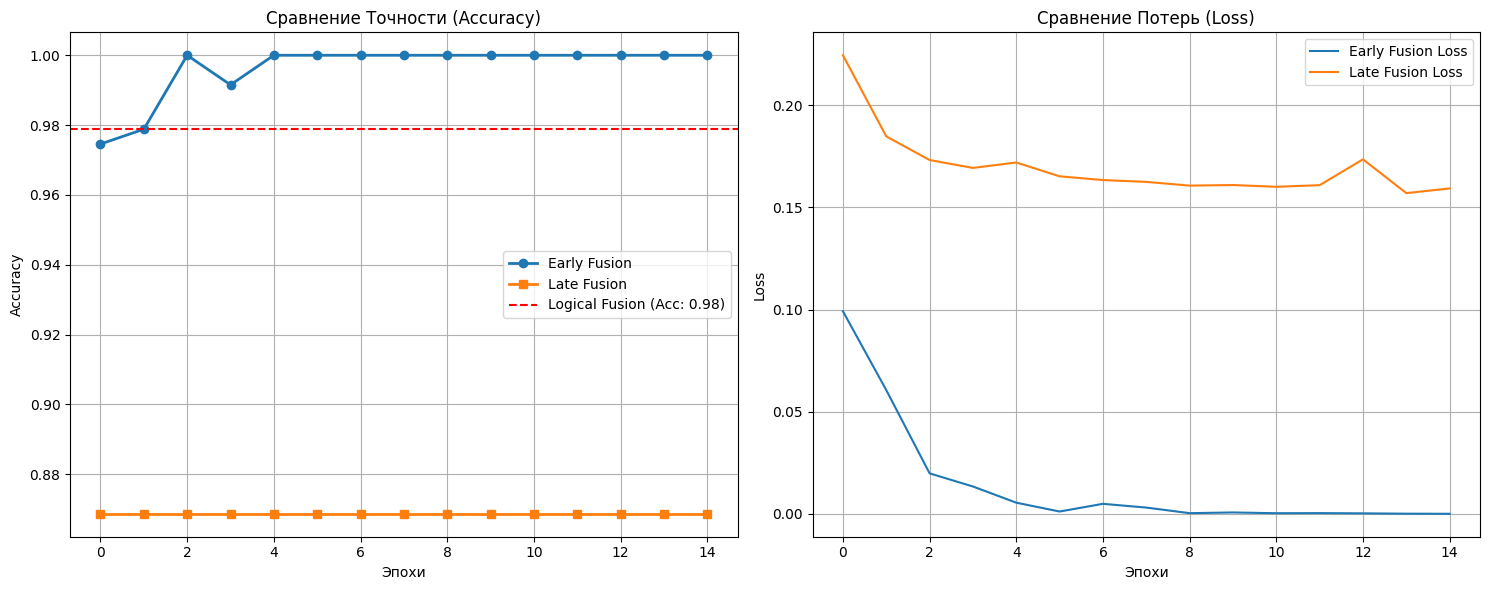

In [31]:
# Блок 7: Визуализация результатов
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))

# График Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_early.history['val_accuracy'], label='Early Fusion', marker='o', linewidth=2)
plt.plot(history_late.history['val_accuracy'], label='Late Fusion', marker='s', linewidth=2)
plt.axhline(y=acc_logical, color='r', linestyle='--', label=f'Logical Fusion (Acc: {acc_logical:.2f})')

plt.title('Сравнение Точности (Accuracy)')
plt.xlabel('Эпохи')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# График Loss
plt.subplot(1, 2, 2)
plt.plot(history_early.history['val_loss'], label='Early Fusion Loss')
plt.plot(history_late.history['val_loss'], label='Late Fusion Loss')

plt.title('Сравнение Потерь (Loss)')
plt.xlabel('Эпохи')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()